# 1. LIBRERÍAS

In [2]:
from deepface import DeepFace
from datetime import datetime

import cv2, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. VARIABLES GLOBALES

In [3]:
detector_backends = ['opencv', 'retinaface','mtcnn', 'ssd', 'dlib', 'mediapipe', 'yolov8', 'centerface','skip']
DET_BACK = detector_backends[1]

In [4]:
models = ['VGG-Face', 'Facenet', 'Facenet512', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib', 'ArcFace', 'SFace', 'GhostFaceNet']
MODEL = models[1]

In [5]:
distances=['cosine', 'euclidean', 'euclidean_l2']
DISTANCE = distances[1]

In [6]:
db_dir = 'my_db'
target_dir = 'my_ref_db'
tmp_dir='tmp'

In [7]:
user_dict={'user001':'Scarlet',
           'user002':'Will',
           'user003':'Leonardo',
           'user004':'Gal',
           'user005':'Daniel',
           'user006':'Elijah',
           'user007':'David'}

# 3. FUNCIONES

## Función para extraer el rostro de una foto: 
**Input:** Ruta de la imagen / detector backend <br>
**Output:** Región que contiene al rostro detectado (formato numpy array)

In [8]:
def getFace(imgPath, backOpt):
    # Cargar la imagen
    img = cv2.imread(imgPath)

    # Detectar rostros en la imagen
    Faces = DeepFace.extract_faces(img, detector_backend = backOpt)

    # Verificar si se detectó algún rostro
    if len(Faces) > 0:
        # Tomar la primera detección (en caso de múltiples rostros)
        Faceborder = Faces[0]['facial_area']

        # Extraer las coordenadas del rostro
        x, y, w, h = Faceborder['x'], Faceborder['y'],Faceborder['w'], Faceborder['h']

        # Recortar el rostro de la imagen
        mainFace = img[y:y+h, x:x+w]

        return mainFace
    else:
        print("No se detectó ningún rostro en la imagen.")

## Función para mostrar un numpy array como imagen
**Input:** Imagen en formato array de numpy <br>
**Output:** Visualización de la imagen.

In [9]:
def showFace(FaceVector):
    plt.imshow(cv2.cvtColor(FaceVector, cv2.COLOR_BGR2RGB))
    plt.show()

## Función para replicar la base de datos de usuarios en una nueva carpeta con solo los rostros de cada imagen
**Input**: Directorio de origen / Directorio de destino
**Output**: Directorio de destino con imagenes de rostros detectados en el directorio origen

In [10]:
def processImageDB(root_dir, new_dir):
    # Recorre todos los archivos en el directorio de origen
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            # Verificar la extensión del archivo
            if filename.endswith(('.jpg', '.jpeg', '.png', '.webp')):
                # Construye la ruta completa del archivo
                src_file = os.path.join(dirpath, filename)
                
                # Aplica la función getFace a la imagen
                face = getFace(src_file, DET_BACK)
                
                # Construye la ruta del archivo de destino
                dst_file = os.path.join(new_dir, os.path.relpath(src_file, root_dir))
                
                # Crea el directorio de destino si no existe
                os.makedirs(os.path.dirname(dst_file), exist_ok=True)
                
                # Guarda la cara extraída en el archivo de destino
                cv2.imwrite(dst_file, face)

## Función para describir mi base da datos original
**Input:** Ruta de la carpeta que contiene las imagenes originales.<br>
**Output:** Lista con las caracteristiscas predichas por DeepFace en base a las fotos de la base de datos.

In [11]:
def describe_myDB(dbPath):
    results_description=[]

    # Recorrer las carpetas de usuarios
    for user_folder in os.listdir(dbPath):
        #user_id = user_folder[-3:]  # Extraer el ID del usuario (001, 002, ..., 006)

        # Recorrer las imágenes del usuario
        for image_file in os.listdir(f'{dbPath}/{user_folder}'):
            image_number = image_file[:-4]  # Extraer el número de la imagen (1, 2, ..., 8)

            # Obtener las predicciones de DeepFace
            print(f'Analizando imagen:{user_folder}/{image_file}')
            result = DeepFace.analyze(img_path=f'{dbPath}/{user_folder}/{image_file}',
                                      actions=['age', 'gender', 'race', 'emotion'],
                                      detector_backend=DET_BACK)

            # Añadir los resultados a la lista
            results_description.append([
                user_folder,
                user_dict[user_folder],
                image_number,
                result[0]['age'],
                result[0]['dominant_gender'],
                result[0]['dominant_race'],
                result[0]['dominant_emotion']
            ])
    return results_description

## Función para identificar a la persona que aparece en una foto

**Input:** ruta de la imagen o array de la imagen.
**Output:** Cadena indicando el nombre de la persona identificada o si no se identifico a nadie.

In [12]:
def IdentifyFace(imgPath, dbPath):
    #Identificando persona
    dfs = DeepFace.find(img_path=imgPath,
                        db_path=dbPath, 
                        model_name=MODEL, 
                        detector_backend=DET_BACK, 
                        distance_metric=DISTANCE)
    
    # Resultados de la verificación de rostros
    ComparisonOutput= dfs[0]

    # Si el dataframe está vacío, devolver "Usuario no autorizado"
    if ComparisonOutput.empty:
        return "Usuario no autorizado"

    # Ubicando el registro con menor valor de distance
    idx = ComparisonOutput['distance'].idxmin()

    # Obteniendo el "user" correspondiente
    userPath = ComparisonOutput.loc[idx, 'identity']

    # Encontrando el nombre correspondiente
    tag = userPath.split('\\')[1]
    return user_dict[tag]

## Función para capturar foto con la camara web

**Input:** objeto camara <br>
**Output:** Ruta de la imagen guardada por la camara web, array de la imagen tomada por la camar web

In [13]:
def captura_imagen(cam):
    # Crea una ventana de visualización
    cv2.namedWindow("Captura de imagen")

    print(f"Mire fijamente a la cámara y sonria...")

    # Muestra la imagen de la cámara en la ventana hasta que se presione la tecla 's'
    while True:
        ret, frame = cam.read()
        if not ret:
            break
        cv2.imshow("Captura de imagen", frame)

        now = datetime.now()
        timestamp = now.strftime("%Y%m%d_%H%M%S")

        # Si se presiona la tecla 's', se guarda la imagen y se sale del bucle
        if cv2.waitKey(1) & 0xFF == ord('s'):
            img_path = f'tmp/capture_{timestamp}.jpg'
            cv2.imwrite(img_path, frame)
            print("Captura tomada exitosamente.....")
            break

    # Cierra la ventana de visualización
    cv2.destroyAllWindows()

    # Devuelve la ruta de la imagen guardada
    return img_path, frame

# 4. PROGRAMA PRINCIPAL

## Procesar base de datos de imagenes

(solo se ejecuta una vez para crear la base de datos de solo caras)

In [31]:
processImageDB(db_dir, target_dir)

## Describir base de datos original

Sirve como verificación de que se estan haciendo buenas predicciones con las imagenes actuales y con la configuración del detctor backend elegido.

In [32]:
db_description = describe_myDB(db_dir)

Analizando imagen:user001/1.png


Action: emotion: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Analizando imagen:user001/2.png


Action: emotion: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Analizando imagen:user001/3.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Analizando imagen:user001/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Analizando imagen:user001/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Analizando imagen:user001/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Analizando imagen:user001/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Analizando imagen:user001/8.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Analizando imagen:user002/1.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Analizando imagen:user002/2.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Analizando imagen:user002/3.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Analizando imagen:user002/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


Analizando imagen:user002/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Analizando imagen:user002/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Analizando imagen:user002/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Analizando imagen:user002/8.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Analizando imagen:user003/1.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Analizando imagen:user003/2.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Analizando imagen:user003/3.png


Action: emotion: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Analizando imagen:user003/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Analizando imagen:user003/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Analizando imagen:user003/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Analizando imagen:user003/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Analizando imagen:user003/8.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Analizando imagen:user004/1.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Analizando imagen:user004/2.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Analizando imagen:user004/3.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Analizando imagen:user004/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Analizando imagen:user004/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Analizando imagen:user004/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Analizando imagen:user004/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Analizando imagen:user004/8.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Analizando imagen:user005/1.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


Analizando imagen:user005/2.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Analizando imagen:user005/3.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Analizando imagen:user005/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Analizando imagen:user005/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Analizando imagen:user005/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Analizando imagen:user005/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Analizando imagen:user005/8.png


Action: emotion: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


Analizando imagen:user006/1.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Analizando imagen:user006/2.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Analizando imagen:user006/3.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Analizando imagen:user006/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Analizando imagen:user006/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Analizando imagen:user006/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Analizando imagen:user006/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Analizando imagen:user006/8.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Analizando imagen:user007/1.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Analizando imagen:user007/2.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Analizando imagen:user007/3.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Analizando imagen:user007/4.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Analizando imagen:user007/5.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Analizando imagen:user007/6.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Analizando imagen:user007/7.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Analizando imagen:user007/8.png


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


In [33]:
# Mostrar los resultados
for result in db_description:
    print(result)

['user001', 'Scarlet', '1', 28, 'Woman', 'white', 'happy']
['user001', 'Scarlet', '2', 27, 'Woman', 'white', 'neutral']
['user001', 'Scarlet', '3', 29, 'Woman', 'white', 'happy']
['user001', 'Scarlet', '4', 27, 'Woman', 'white', 'happy']
['user001', 'Scarlet', '5', 29, 'Woman', 'white', 'fear']
['user001', 'Scarlet', '6', 28, 'Woman', 'white', 'sad']
['user001', 'Scarlet', '7', 28, 'Woman', 'white', 'happy']
['user001', 'Scarlet', '8', 32, 'Woman', 'white', 'fear']
['user002', 'Will', '1', 33, 'Man', 'black', 'happy']
['user002', 'Will', '2', 44, 'Man', 'latino hispanic', 'sad']
['user002', 'Will', '3', 35, 'Man', 'black', 'neutral']
['user002', 'Will', '4', 40, 'Man', 'black', 'happy']
['user002', 'Will', '5', 36, 'Man', 'black', 'happy']
['user002', 'Will', '6', 33, 'Man', 'black', 'happy']
['user002', 'Will', '7', 40, 'Man', 'black', 'neutral']
['user002', 'Will', '8', 33, 'Man', 'black', 'surprise']
['user003', 'Leonardo', '1', 28, 'Man', 'white', 'fear']
['user003', 'Leonardo', '2

In [34]:
users_df = pd.DataFrame(db_description, columns=['Id', 'Name', 'Image','Age', 'dominant_gender', 'dominant_race', 'dominant_emotion'])

In [35]:
users_df.head()

,Id,Name,Image,Age,dominant_gender,dominant_race,dominant_emotion
0,user001,Scarlet,1,28,Woman,white,happy
1,user001,Scarlet,2,27,Woman,white,neutral
2,user001,Scarlet,3,29,Woman,white,happy
3,user001,Scarlet,4,27,Woman,white,happy
4,user001,Scarlet,5,29,Woman,white,fear


In [36]:
users_df.to_excel(f'{tmp_dir}/Description_of_db.xlsx', index=False)

## Reconociendo persona a partir de una foto guardada

In [143]:
test_img =r'Tests\Test05.jpg'
test_path=r'my_db'

In [144]:
FaceUser = IdentifyFace(test_img, test_path)
print(FaceUser)

24-05-30 15:37:27 - Searching Tests\Test05.jpg in 57 length datastore
24-05-30 15:37:30 - find function duration 2.8078343868255615 seconds
David


## Reconociendo a persona a partir de la camara

In [173]:
# Inicializa la cámara
cam = cv2.VideoCapture(0)
# Captura las imágenes
my_image, frame = captura_imagen(cam)
# Cierra la cámara
cam.release()

Mire fijamente a la cámara y sonria...
Captura tomada exitosamente.....


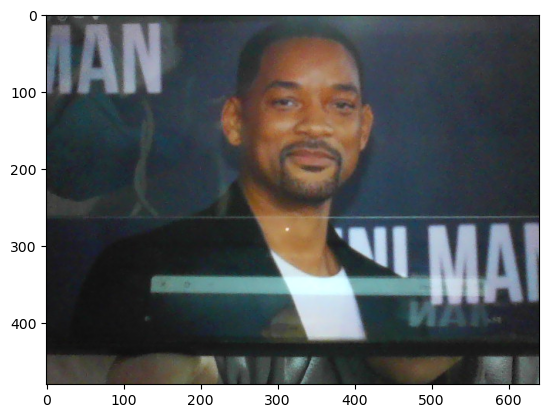

In [174]:
showFace(frame)

In [175]:
FaceUser = IdentifyFace(frame, test_path)
print(FaceUser)

print("###############################################")
if FaceUser=='Usuario no autorizado':
    print("Usted no esta autorizado")
else:
    print(f"\t\tBienvenido {FaceUser}")
print("###############################################")

24-05-30 17:12:35 - Searching [[[ 58  64  73]
  [ 59  64  72]
  [ 76  80  88]
  ...
  [ 73  71  70]
  [ 69  66  68]
  [ 61  58  61]]

 [[ 62  68  74]
  [ 68  73  79]
  [ 78  82  87]
  ...
  [ 69  67  67]
  [ 68  65  67]
  [ 61  58  61]]

 [[ 65  70  72]
  [ 66  71  73]
  [ 66  69  70]
  ...
  [ 62  60  60]
  [ 64  61  63]
  [ 60  57  60]]

 ...

 [[ 74  74  74]
  [ 73  74  74]
  [ 71  75  76]
  ...
  [ 97  95  87]
  [119 116 108]
  [147 144 136]]

 [[ 70  72  73]
  [ 70  73  74]
  [ 68  74  76]
  ...
  [ 98  99  90]
  [124 125 116]
  [150 149 141]]

 [[ 70  73  74]
  [ 69  74  76]
  [ 68  75  77]
  ...
  [107 110 101]
  [134 136 128]
  [149 149 142]]] in 57 length datastore
24-05-30 17:12:39 - find function duration 3.398113489151001 seconds
Will
###############################################
		Bienvenido Will
###############################################


Bienvenido David


In [14]:
DeepFace.stream(db_path= db_dir) 
    #model_name= MODEL,
    #detector_backend= DET_BACK,
    #distance_metric= DISTANCE,    
    #source= 0

24-05-30 17:19:30 - Age model is just built
24-05-30 17:19:34 - Gender model is just built
24-05-30 17:19:34 - Emotion model is just built
24-05-30 17:19:38 - VGG-Face is built
24-05-30 17:20:26 - freezed
24-05-30 17:20:31 - freeze released
24-05-30 17:20:33 - Hello, my_db\user007\6.png
24-05-30 17:20:33 - freezed
24-05-30 17:20:38 - freeze released
24-05-30 17:20:39 - Hello, my_db\user007\4.png
24-05-30 17:20:39 - freezed
24-05-30 17:20:44 - freeze released
24-05-30 17:20:45 - Hello, my_db\user007\4.png
24-05-30 17:20:46 - freezed
24-05-30 17:20:51 - freeze released
24-05-30 17:20:52 - freezed
24-05-30 17:20:57 - freeze released
24-05-30 17:20:58 - Hello, my_db\user002\4.png
24-05-30 17:20:58 - 🔴 could not broadcast input array from shape (720,1200,3) into shape (112,112,3)
24-05-30 17:20:58 - freezed
24-05-30 17:21:04 - freeze released
24-05-30 17:21:05 - freezed
24-05-30 17:21:10 - freeze released
24-05-30 17:21:11 - Hello, my_db\user007\4.png
24-05-30 17:21:11 - freezed
24-05-30 17

KeyboardInterrupt: 

: 